#Q1

##PART (1) Projection Matrix and Reconstruction Error

In [30]:
import numpy as np
import math
import cv2
import random
import matplotlib.pyplot as plt
# for points https://yangcha.github.io/iview/iview.html

In [29]:
tmp = np.zeros((20,3))
tmp[:,0] = np.array([[7, 4, 5, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tmp[:,1] = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 0]])
tmp[:,2] = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]])
tmp = tmp.astype('int64')
imgpts = np.zeros((20,2))
imgpts[:,0] = np.array([[2597, 2074, 2237, 1664, 1795, 1932, 2083, 2247, 2421, 2619, 1546, 1545, 1544, 1543, 1543, 1545, 1545, 1545, 1410, 1281]])
imgpts[:,1] = np.array([[1948, 1856, 1887,1615, 1629, 1648, 1666, 1687, 1710, 1733, 1764, 1931, 2089, 2252, 2403, 2557, 2706, 2853, 1608, 1624]])
imgpts = imgpts.astype('int64')

##Scale 28x28

###(a) Original Data as input

In [22]:
#@title
def getProjectionMatrix(worldpts, imgpts):
  A = np.zeros((2*len(worldpts), 12))
  j = 0
  for i in range(len(worldpts)):
    A[j,:] = np.concatenate([worldpts[i],np.array([1,0,0,0,0]),worldpts[i]*(-imgpts[i][0]), np.array([-imgpts[i][0]])])
    A[j+1,:] = np.concatenate([np.array([0,0,0,0]),worldpts[i], np.array([1]), worldpts[i]*(-imgpts[i][1]), np.array([-imgpts[i][1]])])
    j += 2

  u,s,v = np.linalg.svd(A)
  P = v[-1,:]/v[-1,-1]
  P = P.reshape(3,4)
  return P

def getReconstructionError(worldpts, imgpts, proj_mat):
  one_mat = np.ones(len(worldpts))
  diffsquare = 0
  for i in range(len(worldpts)):
    imgpt = imgpts[i]
    hg_imgpt = np.dot(proj_mat, np.concatenate([worldpts[i],[1]]))
    cal_imgpt = np.array([ (hg_imgpt[0]/hg_imgpt[2]), (hg_imgpt[1]/ hg_imgpt[2])])
    diffsquare += (cal_imgpt[0] - imgpt[0])**2 + (cal_imgpt[1] - imgpt[1])**2
  
  return math.sqrt(diffsquare / len(worldpts))


In [31]:
worldpts = tmp*28
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 2.26141400e+00  5.45508957e-01 -3.88319434e+00  1.54445681e+03]
 [-1.43206934e+00  6.61076373e+00  1.48704803e+00  1.59794108e+03]
 [-1.22258391e-03  3.53805356e-04  6.43465099e-04  1.00000000e+00]]

Reconstruction Error : 
2.3065780243794394


###(b) Normalized World Points and Image Points as input ( Without denormalizing projection Matrix )


In [25]:
#@title 
def getTransformationT(imgpts):
  n = len(imgpts)
  xbar = np.sum(imgpts, axis = 0)[0] / n
  ybar = np.sum(imgpts, axis = 0)[1] / n

  sum = 0
  for i in range(n):
    sum += math.sqrt((imgpts[i][0] - xbar)**2  + (imgpts[i][1] - ybar)**2)

  dbar = (sum) / n
  root2 = math.sqrt(2)

  T = np.array([[root2/dbar, 0, -root2*xbar/dbar],
                [0, root2/dbar, -root2*ybar/dbar],
                [0, 0, 1]])
  return T

def getTransformationU(worldpts):
  n = len(worldpts)
  xbar = np.sum(worldpts, axis = 0)[0] / n
  ybar = np.sum(worldpts, axis = 0)[1] / n
  zbar = np.sum(worldpts, axis = 0)[2] / n

  sum = 0
  for i in range(n):
    sum += math.sqrt((worldpts[i][0] - xbar)**2  + (worldpts[i][1] - ybar)**2 + (worldpts[i][2] - zbar)**2)

  dbar = (sum) / n
  root3 = math.sqrt(3)

  U = np.array([[root3/dbar, 0, 0, -root3*xbar/dbar],
                [0, root3/dbar, 0, -root3*ybar/dbar],
                [0, 0, root3/dbar, -root3*zbar/dbar],
                [0, 0, 0, 1]])
  return U

def getNormalizedPoints(imgpts, worldpts):
  T = getTransformationT(imgpts)
  U = getTransformationU(worldpts)
  n = len(imgpts)

  norm_imgpts = np.zeros(np.shape(imgpts)) 
  for i in range(n):
    imgpt = imgpts[i]
    hg_imgpt = np.dot(T, np.concatenate([imgpts[i],[1]]))
    norm_imgpt = np.array([(hg_imgpt[0]), (hg_imgpt[1])])
    norm_imgpts[i,:] = norm_imgpt
   
  
  norm_worldpts = np.zeros(np.shape(worldpts)) 
  for i in range(n):
    worldpt = worldpts[i]
    hg_worldpt = np.dot(U, np.concatenate([worldpts[i],[1]]))
    norm_worldpt = np.array([(hg_worldpt[0]), (hg_worldpt[1]), (hg_worldpt[2])])
    norm_worldpts[i,:] = norm_worldpt
  
  return T, U , norm_imgpts, norm_worldpts


In [26]:
T, U, norm_imgpts, norm_worldpts = getNormalizedPoints(imgpts, worldpts)
norm_proj_mat = getProjectionMatrix(norm_worldpts, norm_imgpts)
print('Normalized Projection Matrix is : ')
print(norm_proj_mat)

recon_err = getReconstructionError(norm_worldpts, norm_imgpts, norm_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Normalized Projection Matrix is : 
[[ 0.72441007 -0.01686027 -0.8327698  -0.11930024]
 [ 0.15476356  0.95172998  0.0252397   0.06571711]
 [-0.07169352  0.02077465  0.05002942  1.        ]]

Reconstruction Error : 
0.0063368951162561995


###(c) Normalized World Points and Image Points as input ( With denormalizing projection Matrix )

In [27]:
deno_proj_mat = np.dot(np.linalg.inv(T), np.dot(norm_proj_mat, U))
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, deno_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 2.26141400e+00  5.45508957e-01 -3.88319434e+00  1.54445681e+03]
 [-1.43206934e+00  6.61076373e+00  1.48704803e+00  1.59794108e+03]
 [-1.22258391e-03  3.53805356e-04  6.43465099e-04  1.00000000e+00]]

Reconstruction Error : 
2.3099480440418367


##Scale 2800x2800

###(a) Original Data as input

In [ ]:
worldpts = tmp*2800
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 2.26141389e-02  5.45508863e-03 -3.88318831e-02  1.54445681e+03]
 [-1.43206941e-02  6.61076358e-02  1.48705551e-02  1.59794108e+03]
 [-1.22258394e-05  3.53805307e-06  6.43469734e-06  1.00000000e+00]]

Reconstruction Error : 
2.3065780178594983


###(b) Normalized World Points and Image Points as input ( Without denormalizing projection Matrix )


In [ ]:
T, U, norm_imgpts, norm_worldpts = getNormalizedPoints(imgpts, worldpts)
norm_proj_mat = getProjectionMatrix(norm_worldpts, norm_imgpts)
print('Normalized Projection Matrix is : ')
print(norm_proj_mat)

recon_err = getReconstructionError(norm_worldpts, norm_imgpts, norm_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Normalized Projection Matrix is : 
[[ 0.72441007 -0.01686027 -0.8327698  -0.11930024]
 [ 0.15476356  0.95172998  0.0252397   0.06571711]
 [-0.07169352  0.02077465  0.05002942  1.        ]]

Reconstruction Error : 
0.006336895116256213


###(c) Normalized World Points and Image Points as input ( With denormalizing projection Matrix )

In [ ]:
deno_proj_mat = np.dot(np.linalg.inv(T), np.dot(norm_proj_mat, U))
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, deno_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 2.26141389e-02  5.45508863e-03 -3.88318831e-02  1.54445681e+03]
 [-1.43206941e-02  6.61076358e-02  1.48705551e-02  1.59794108e+03]
 [-1.22258394e-05  3.53805307e-06  6.43469734e-06  1.00000000e+00]]

Reconstruction Error : 
2.3099480440417692


##PART (2) K R and C

```
M = K \[R -RC] = \[KR -KRC] 
M = \[A B]
A = KR
B = -**KRC**
B = -AC
C = -Ainv.B
QR Decomposition of Ainv = R and K
```

In [28]:
#scale = 28
A = proj_mat[:,0:3]
B = proj_mat[:,3]*-1

A_inv = np.linalg.pinv(A)
q, r = np.linalg.qr(A_inv)

R = q.T
K = np.linalg.inv(r)
K = K / K[2][2]
C = np.dot(A_inv,B)

print('K : ')
print(K)
print('R : ')
print(R)
print('T : ')
print(C)

K : 
[[ 1.77363474e+03 -8.44957381e+02 -2.49293093e+03]
 [-0.00000000e+00 -4.17440325e+03  2.48120375e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R : 
[[-0.43904151  0.10559533 -0.89223998]
 [-0.26899209 -0.96296668  0.01839629]
 [-0.85725481  0.24808223  0.45118666]]
T : 
[1372.79856072 -207.08908543 1168.09856693]


##PART(3) RANSAC

###(A) Implementation

In [ ]:
def ransac(worldpts, imgpts, no_iteration):
  err_min = 100
  final_proj_mat = None
  for i in range(no_iteration):
    index = random.sample(range(0, len(worldpts)), 7)
    rworldpts = [worldpts[i] for i in index]
    rimgpts = [imgpts[i] for i in index]
    proj_mat = getProjectionMatrix(rworldpts, rimgpts)
    recon_err = getReconstructionError(rworldpts, rimgpts, proj_mat)
    
    if recon_err < err_min:
      err_min = recon_err
      final_proj_mat = proj_mat

    # print('Reconstruction Error : ', err_min)
  return final_proj_mat, err_min
worldpts = tmp*28
proj_mat, error = ransac(worldpts, imgpts, 1000)
print('Projection Matrix ', proj_mat)
print('Error ', error)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Projection Matrix  [[ 2.18616107e+00  5.97211893e-01 -3.74742028e+00  1.54437361e+03]
 [-1.45925873e+00  6.72983949e+00  1.79754245e+00  1.59120672e+03]
 [-1.25846064e-03  3.84534728e-04  7.45998882e-04  1.00000000e+00]]
Error  0.3522862515220923


###(B) Numerical

###### for p>=95% and (1-e)=80%
We know that,
$T = \frac{log(1-p)}{log(1-(1-e)^s)}$

$T = \frac{log(1-0.95)}{log(1-(0.8)^6)}$

$T \geq 10$

###### so we need at least 10 iterations

###(C) Probability of success of RANSAC vs Number of iterations required.

$T = \frac{log(1-p)}{log(1-(1-e)^s)}$

$p = {1 - ((1 - (1 - e)^s)^T}$

$p = {1 - ((1 - (0.8)^6)^T}$

$p = {1 - (0.7378)^T}$

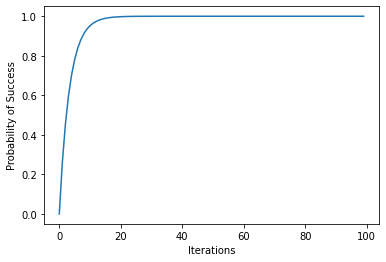

In [ ]:
iterations = range(100)
prob_success = []

for i in iterations:
  prob_success.append(1 - 0.7378**i)

plt.plot(iterations, prob_success) 
  
plt.xlabel('Iterations') 
plt.ylabel('Probability of Success') 
# plt.title('') 
  
# function to show the plot 
plt.show() 

#Q2

##(1) Zhangs Method


In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

path = '/content/drive/MyDrive/Sem 4/CV/Assignment_1/calibration-data/'
imgs = []
for i in range(56,71):
  imgs.append(path + "IMG_54"+str(i)+".JPG")


arr = []
objpts = [] 
imgpts = [] 

for i in range(6):
  for j in range(8):
    arr.append([j*28,i*28,0.0])

arr = np.asarray(arr,dtype=np.float32)

for i in imgs:
  img = cv2.imread(i)
  img = cv2.resize(img, (0,0),fx = 0.1 , fy = 0.1)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, corners = cv2.findChessboardCorners(gray, (8,6),None)

  if ret == True:
      objpts.append(arr)
      corners2 = cv2.cornerSubPix(gray,corners,(12,12),(-1,-1),(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
      img1 = cv2.drawChessboardCorners(img, (8,6), corners2, ret)
      # plt.figure(figsize=(4,4))
      # plt.imshow(img1)
      imgpts.append(corners2)


ret, mtx, dist,rvecs, tvecs = cv2.calibrateCamera(objpts,imgpts, gray.shape[::-1],None,None)



In [34]:
print('Camera Matrix ', mtx)
print('dist vect ', dist)
print('rvecs', rvecs)
print('tvecs', tvecs)

Camera Matrix  [[1.36246252e+03 0.00000000e+00 3.30217759e+02]
 [0.00000000e+00 1.36526659e+03 1.44909038e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist vect  [[ 7.56146456e-02  1.17629337e+01 -1.77105391e-02  2.74124817e-02
  -1.95345162e+02]]
rvecs [array([[-0.01821178],
       [-0.04426762],
       [-0.00315066]]), array([[-0.01055999],
       [ 0.22885528],
       [ 0.03433164]]), array([[-0.01267193],
       [-0.41301102],
       [-0.03501483]]), array([[ 0.0141459 ],
       [-0.61591044],
       [-0.07664029]]), array([[-5.11623759e-05],
       [ 3.10742940e-01],
       [ 6.47360393e-02]]), array([[-0.32603043],
       [-0.2186353 ],
       [-0.01670126]]), array([[-0.19601047],
       [-0.38246907],
       [-0.00321999]]), array([[ 0.24179564],
       [-0.32038508],
       [ 0.0248227 ]]), array([[0.30892408],
       [0.06687272],
       [0.06975605]]), array([[ 0.34683028],
       [-0.5612631 ],
       [-0.05985725]]), array([[ 0.22224089],
       [-0.40229467],
   

##(2) Overlay Wireframe




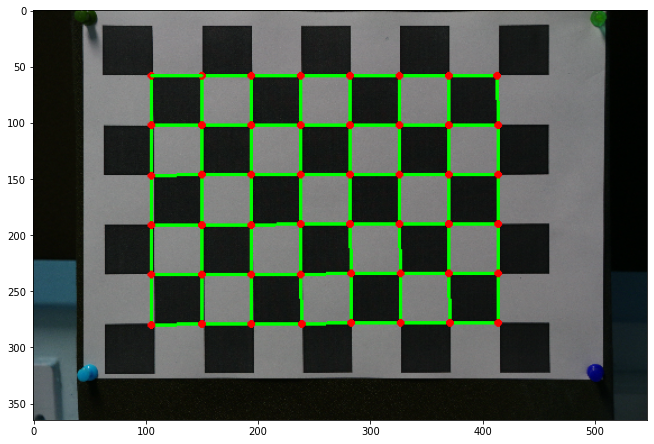

In [39]:
p = np.dot(mtx,np.column_stack(((cv2.Rodrigues(rvecs[0]))[0] ,tvecs[0])))

#Get Image points using p matrix
worldpts = objpts[0]
imgpts = []
for worldpt in worldpts:
  worldpt = np.append(worldpt, 1)
  imgpt = np.dot(p, np.array(worldpt).T)
  imgpts.append([int(imgpt[0]/imgpt[2]), int(imgpt[1]/imgpt[2])])


img = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_1/calibration-data/IMG_5456.JPG',cv2.IMREAD_COLOR)
img = cv2.resize(img, (0,0),fx = 0.1 , fy = 0.1)

tmp = np.zeros((6,8),list)
for i in range(0,6):
  for j in range(0,8):
  
    tmp[i][j] = imgpts[8*i + j]

imgpts = tmp

#line
for i in range(len(imgpts)):
  prev = tuple(imgpts[i][0])
  for j in range(len(imgpts[0])):
    cur = tuple(imgpts[i][j])
    img = cv2.line(img, prev, cur, (0,255,0), 2)
    prev = cur

for j in range(len(imgpts[0])):
  prev = tuple(imgpts[0][j])
  for i in range(len(imgpts)):
    cur = tuple(imgpts[i][j])
    img = cv2.line(img, prev, cur, (0,255,0), 2)
    prev = cur


#circle
for i in range(len(imgpts)):
  for j in range(len(imgpts[0])):
    img = cv2.circle(img, tuple(imgpts[i][j]), 2, (255, 0, 0), 2)



img = cv2.line(img, tuple(imgpts[0][1]), tuple(imgpts[0][0]), (0,255,0),2)
plt.figure(figsize = (11,11))
plt.imshow(img)

#Q3

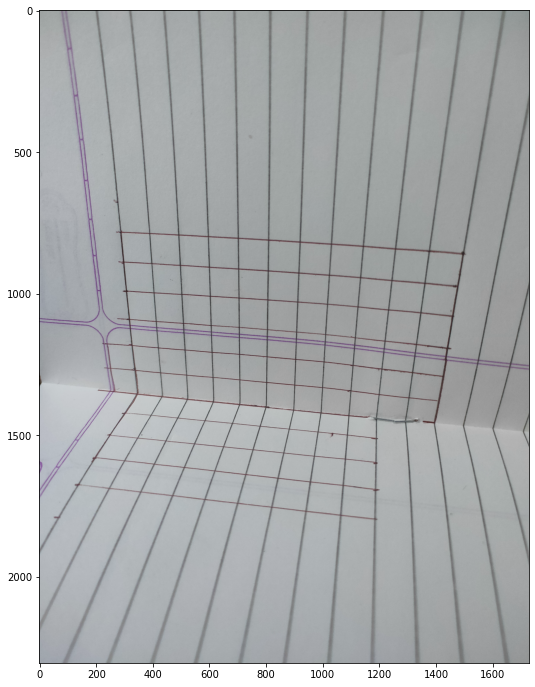

In [43]:
img = cv2.imread('/content/drive/MyDrive/Sem 4/CV/Assignment_1/images/calib_book.jpg',30)
plt.figure(figsize = (12,12))
plt.imshow(img)

In [ ]:
 
tmp = np.zeros((12,3))
tmp[:,0] = np.array([[0, 1, 2, 3, 3, 3, 4, 4, 5, 4, 9, 8]])
tmp[:,1] = np.array([[2, 0, 3, 2, 1, 0, 2, 1, 2, 0, 0, 0]])
tmp[:,2] = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]])
tmp = tmp.astype('int64')
imgpts = np.zeros((12,2))
imgpts[:,0] = np.array([[ 650,  861, 1022, 1215, 1223, 1223, 1409, 1412, 1612, 1359, 2389, 2189]])
imgpts[:,1] = np.array([[2355, 2732, 2215, 2410, 2595, 2769, 2426, 2605, 2452, 2919, 3024, 2867]])
imgpts = imgpts.astype('int64')

##DLT

###Original Data as input

In [ ]:
worldpts = tmp*9
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 1.96591404e+01 -2.29188757e+00 -1.39856590e+01  6.74866167e+02]
 [ 3.54179341e-01 -2.30911911e+01 -3.03883731e+00  2.71148581e+03]
 [-6.25659240e-04 -1.51523031e-03 -5.87601126e-03  1.00000000e+00]]

Reconstruction Error : 
4.339541282850863


###Normalised Data points witout denormalizing projection Matrix

In [ ]:
T, U, norm_imgpts, norm_worldpts = getNormalizedPoints(imgpts, worldpts)
norm_proj_mat = getProjectionMatrix(norm_worldpts, norm_imgpts)
print('Normalized Projection Matrix is : ')
print(norm_proj_mat)

recon_err = getReconstructionError(norm_worldpts, norm_imgpts, norm_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Normalized Projection Matrix is : 
[[ 0.81003711 -0.00850019 -0.23303606 -0.02762398]
 [ 0.07858898 -0.75522686  0.48628015 -0.00703496]
 [-0.00739349 -0.01778723 -0.07198782  1.        ]]

Reconstruction Error : 
0.01405714903405372


###Normalized Data Points with denormalizing Projection Matrix

In [ ]:
deno_proj_mat = np.dot(np.linalg.inv(T), np.dot(norm_proj_mat, U))
proj_mat = getProjectionMatrix(worldpts, imgpts)
print('Projection Matrix is : ')
print(proj_mat)
recon_err = getReconstructionError(worldpts.copy(), imgpts, deno_proj_mat)
print()
print('Reconstruction Error : ')
print(recon_err)

Projection Matrix is : 
[[ 1.96591404e+01 -2.29188757e+00 -1.39856590e+01  6.74866167e+02]
 [ 3.54179341e-01 -2.30911911e+01 -3.03883731e+00  2.71148581e+03]
 [-6.25659240e-04 -1.51523031e-03 -5.87601126e-03  1.00000000e+00]]

Reconstruction Error : 
4.334989230518719


##K R and C

In [ ]:
A = proj_mat[:,0:3]
B = proj_mat[:,3]*-1

A_inv = np.linalg.pinv(A)
q, r = np.linalg.qr(A_inv)

R = q.T
K = np.linalg.inv(r)
K = K / K[2][2]
C = np.dot(A_inv,B)

print('K : ')
print(K)
print('R : ')
print(R)
print('C : ')
print(C)

K : 
[[ 3.44920858e+03  1.01355557e+01  1.97105843e+03]
 [-0.00000000e+00 -3.54678784e+03  1.41403434e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R : 
[[-0.99307748 -0.03017152  0.11352002]
 [ 0.05725808 -0.96819213  0.24356829]
 [ 0.10256036  0.24838212  0.96321737]]
C : 
[ 74.37871856 100.62661529 136.31556074]


##RANSAC

In [ ]:
worldpts = tmp*28
proj_mat, error = ransac(worldpts, imgpts, 1000)
print('Projection Matrix ', proj_mat)
print('Error ', error)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Projection Matrix  [[ 6.69782441e+00  4.99305959e-02 -4.78102372e+00  6.53075662e+02]
 [ 4.84592906e-01 -5.97680891e+00 -1.41819286e+00  2.71158555e+03]
 [-7.26381457e-05  1.65223441e-04 -2.06578378e-03  1.00000000e+00]]
Error  0.2715310340288914
